In [1]:
import matplotlib.pyplot as plt
from copy import deepcopy
from cv2 import resize
import pandas as pd
import numpy as np
import random
import cv2
import os

### Get FileNames and Separate Categories

In [2]:
path = "SOCOFing\\Real\\"
pathMod = ["SOCOFing\\Altered\\Altered-Easy\\", "SOCOFing\\Altered\\Altered-Medium\\", 
           "SOCOFing\\Altered\\Altered-Hard\\"]

real = [path + a for a in os.listdir(path)]

altObl = []
altCR = []
altZcut = []

for p in pathMod:
    for file in os.listdir(p):
        if "Obl" in file:
            altObl.append(p+file)
        elif "CR" in file:
            altCR.append(p+file)
        elif "Zcut" in file:
            altZcut.append(p+file)
            
print("We dispose of " + str(len(real)) + " non altered fingerprints, " + str(len(altObl)) + 
      " altered by obliteration, " + str(len(altCR)) + " altered by central rotation and " + 
      str(len(altZcut)) + " altered by Z cut.")

We dispose of 6000 non altered fingerprints, 17854 altered by obliteration, 16439 altered by central rotation and 14977 altered by Z cut.


#### Plot Examples

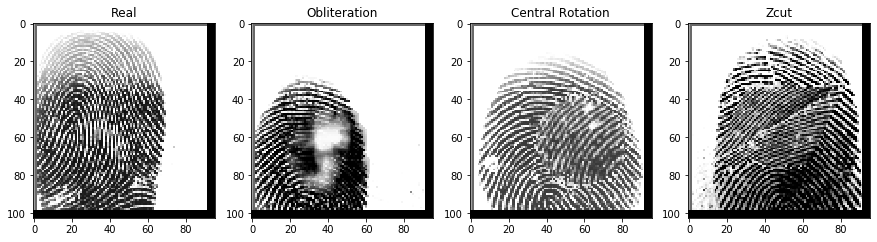

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(15,15))

for axes, lst, name in zip(ax, [real, altObl, altCR, altZcut], ["Real",  "Obliteration", "Central Rotation", "Zcut"]):
    im = cv2.imread(lst[random.randrange(len(lst))], cv2.IMREAD_GRAYSCALE)
    axes.title.set_text(name)
    axes.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

### Split and Shuffle Dataset

In [4]:
from keras.utils import to_categorical

# Validation set

num2Val = 600

x_val_names = np.concatenate((real[:num2Val], altObl[:num2Val], altCR[:num2Val], altZcut[:num2Val]))
y_val = np.concatenate((np.zeros(num2Val), np.ones(num2Val), np.ones(num2Val)*2, np.ones(num2Val)*3))

indices = np.arange(len(x_val_names))
np.random.shuffle(indices)

x_val_names = x_val_names[indices]
y_val = to_categorical(y_val[indices])
    
# Training set
    
# To feed neural network with equal number of examples of every category
lim = min([len(real), len(altObl), len(altCR), len(altZcut)])

x_train_names = np.concatenate((real[num2Val:lim], altObl[num2Val:lim], altCR[num2Val:lim], altZcut[num2Val:lim]))
y_train = np.concatenate((np.zeros(len(real[num2Val:lim])), np.ones(len(real[num2Val:lim])), 
                          np.ones(len(real[num2Val:lim]))*2, np.ones(len(real[num2Val:lim]))*3))

indices = np.arange(len(x_train_names))
np.random.shuffle(indices)

x_train_names = x_train_names[indices]
y_train = y_train[indices]

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\comp

### Load Validation Set

In [5]:
scale = 2
FINGER_SIZE = (int(103/scale), int(96/scale))

x_val = []

for name in x_val_names:
    im = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    x_val.append(resize(im.astype('float32')/255,
                        FINGER_SIZE))
    
x_val = np.array(x_val).reshape(len(x_val), x_val[0].shape[0], x_val[0].shape[1], 1)

### Model

In [6]:
from keras.utils import Sequence

In [7]:
ipt_shape = x_val[0].shape
batch_size = 100

In [8]:
class myGenerator(Sequence) :

    def __init__(self, data, label, batch_size) :
        self.data = data
        self.label = label
        self.batch_size = batch_size


    def __len__(self) :
        # Denotes the number of batches per epoch
        return np.ceil((len(self.data)/self.batch_size)).astype(int)

    def __getitem__(self, idx):
        
        batch_x_names = deepcopy(self.data[idx * batch_size : (idx+1) * batch_size])
        batch_y = to_categorical(deepcopy(self.label[idx * batch_size : (idx+1) * batch_size]))
        
        batch_x = []
        
        for name in batch_x_names:
            im = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
            batch_x.append(resize(im.astype('float32')/255,
                                  FINGER_SIZE))
        
        batch_x = np.asarray(batch_x).reshape(len(batch_x), batch_x[0].shape[0], batch_x[0].shape[1], 1)
        
        return np.array(batch_x), np.array(batch_y)

In [9]:
training_gen = myGenerator(x_train_names, y_train, batch_size)

We create a convolutional model with regularization layers like Batch Normalization with lower momentum than default to avoid unestable loss in validation set.

In [10]:
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', 
                 input_shape=(ipt_shape[0], ipt_shape[1], 1)))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.7))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.7))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.7))

model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(4, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 51, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 51, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 51, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 25, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 25, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 25, 128)      

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
import time

n_epochs = 40

start = time.clock()

history = model.fit_generator(training_gen, epochs=n_epochs, 
                              steps_per_epoch = int(len(x_train_names)/batch_size),
                              verbose=1, validation_data=(x_val, y_val))

t = time.clock() - start

print(t)

s = t%60
m = int(t/60)
if m >= 60: 
    h = int(m/60)
    m = m - h*60
    print(str(h) + "h", end="")

print(str(m) + "m" + str(s) + "s")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


Epoch 1/40
216/216 [==============================] - 610s 3s/step - loss: 1.6839 - accuracy: 0.4364 - val_loss: 0.8535 - val_accuracy: 0.5950
Epoch 2/40
216/216 [==============================] - 664s 3s/step - loss: 0.7896 - accuracy: 0.6181 - val_loss: 0.7042 - val_accuracy: 0.6762
Epoch 3/40
216/216 [==============================] - 695s 3s/step - loss: 0.6192 - accuracy: 0.6857 - val_loss: 3.7775 - val_accuracy: 0.4338
Epoch 4/40
216/216 [==============================] - 685s 3s/step - loss: 0.5331 - accuracy: 0.7237 - val_loss: 0.4915 - val_accuracy: 0.7517
Epoch 5/40
216/216 [==============================] - 668s 3s/step - loss: 0.4753 - accuracy: 0.7480 - val_loss: 0.5524 - val_accuracy: 0.7475
Epoch 6/40
216/216 [==============================] - 682s 3s/step - loss: 0.4284 - accuracy: 0.7876 - val_loss: 0.4436 - val_accuracy: 0.8033
Epoch 7/40
216/216 [==============================] - 688s 3s/step - loss: 0.3875 - accuracy: 0.8185 - val_loss: 0.3720 - val_accuracy: 0.8504

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


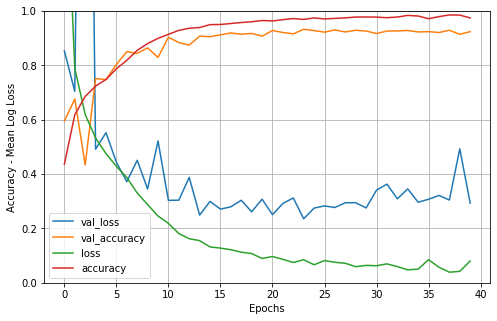

In [13]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0,1]
plt.show()

### Study results

In [14]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, figsize=(8, 6)):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [15]:
y_out = model.predict(x_val, verbose=1)

2400/2400 [==============================] - 29s 12ms/step


In [16]:
y_out[0]

array([9.9641764e-01, 2.8388582e-05, 7.6266324e-06, 3.5463131e-03],
      dtype=float32)

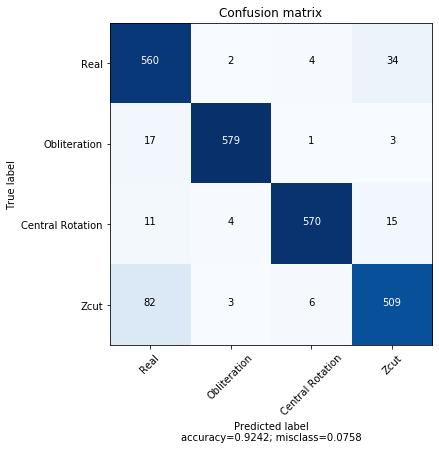

In [17]:
from sklearn.metrics import confusion_matrix

lab = ["Real",  "Obliteration", "Central Rotation", "Zcut"]

y_out_tag = [lab[np.argmax(tag)] for tag in y_out]
y_val_tag = [lab[np.argmax(tag)] for tag in y_val]

# We calculate the confusion matrix. confusion_matrix(y_true, y_pred)
cm = confusion_matrix(y_val_tag, y_out_tag, labels = lab)

# Plot the confusion matrix
plot_confusion_matrix(cm, lab, normalize=False)

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_val_tag, y_out_tag))

                  precision    recall  f1-score   support

Central Rotation       0.98      0.95      0.97       600
    Obliteration       0.98      0.96      0.97       600
            Real       0.84      0.93      0.88       600
            Zcut       0.91      0.85      0.88       600

        accuracy                           0.92      2400
       macro avg       0.93      0.92      0.92      2400
    weighted avg       0.93      0.92      0.92      2400



### Attempt to reduce variability

In order to reduce variability, I tried to cut the white space between borders and the fingerprint. For this task, I planned to cut it studying the mean and std of the vertical and horizontal sum. However, it doesn't worked as expected, because of the variability of white space variance (because some noise, or bad cleaning of de sensor) and the system wasn't able to learn with this bad performance. This criteria could be improved with some image filtering like erode, but this slows down the training, and the performance of the system described without cropping was enough for the purpose of this study.

_**Note**. As you could see in the upper part of this notebook, there are some black columns and row at the left and bottom of the images. This black columns and black aren't always with the same width, and after a study, I've seen that them are at:_

*Right positions: {87, 89, 90, 91, 92, 95}*

*Bottom positions: {80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102}*

*So, I decided to study where are them in every case, and remove them.*

In [19]:
def cutImage(im):
    
    # We cut the gray edges (top and left)
    im = im[2:,2:]

    ax = np.sum(im, axis = 0)
    ay = np.sum(im, axis = 1)
    
    # Find where the black edges are (bottom and right), 
    # there aren't in the same positions always
    posx = np.where(ax > 0)
    posy = np.where(ay > 0)

    # Cut them
    im = im[:, list(set(posx[0]))]
    im = im[list(set(posy[0])), :]
    
    ax = np.sum(im, axis = 0)
    ay = np.sum(im, axis = 1)

    # Margin (in numbers of std) where we want to crop (if a 
    # column or row is bigger than mean + margin*std or 
    # lower than mean - margin*std, it will be cropped)
    margin = 1.5

    stx = np.std(ax)
    sty = np.std(ay)
    
    meanx = np.mean(ax)
    meany = np.mean(ay)

    posx = np.where((ax < meanx+margin*stx) & (ax > meanx-margin*stx))
    posy = np.where((ay < meany+margin*sty) & (ay > meany-margin*sty))

    im = im[:, list(set(posx[0]))]
    im = im[list(set(posy[0])), :]

    return im

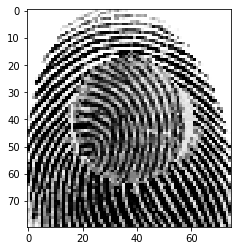

Press "q" for stop showing cropped examples q


In [20]:
from IPython.display import clear_output

ipt = ""
while ipt != "q":
    clear_output(wait=True)
    im = cv2.imread(x_train_names[random.randrange(len(x_train_names))], 
                    cv2.IMREAD_GRAYSCALE)
    plt.imshow(cv2.cvtColor(cutImage(im), cv2.COLOR_BGR2RGB))
    plt.show()
    ipt = input("Press \"q\" for stop showing cropped examples ")
    